In [1]:
import os, h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from track import SOLAR_LOGG, SOLAR_TEFF, SOLAR_ZX

print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
path = 'data/yrec_grid.h5'
h5f = h5py.File(path, 'r')

dset = h5f['data']
data = np.array(dset)
columns = dset.attrs['columns']

h5f.close()

In [4]:
df = pd.DataFrame(data, columns=columns)
del data

In [5]:
df.head()

,EEP,M/Msun,Age(Gyr),[Fe/H],fk,Rocrit,Prot(days),log(Teff)(K),R/Rsun,log(Z/X)(surface)
0,1.000000,1.06,0.036089,0.1,6.0,2.75,0.374777,3.752937,0.987328,-1.692670
1,1.045365,1.06,0.037402,0.1,6.0,2.75,0.383608,3.751863,0.979282,-1.692682
2,1.067487,1.06,0.039110,0.1,6.0,2.75,0.395994,3.751114,0.975430,-1.692698
3,1.069806,1.06,0.041330,0.1,6.0,2.75,0.412794,3.750794,0.975226,-1.692721
4,1.079711,1.06,0.044216,0.1,6.0,2.75,0.435389,3.750821,0.976990,-1.692753


In [7]:
mask = df['Prot(days)'] == 0
df.drop(df.loc[mask].index, inplace=True)

In [6]:
df['log(R/Rsun)'] = np.log10(df['R/Rsun'])
df['log(g)'] = SOLAR_LOGG + np.log10(df['M/Msun']) - 2 * df['log(R/Rsun)']
df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(SOLAR_TEFF))
df['[Fe/H](surface)'] = df['log(Z/X)(surface)'] - np.log10(0.023)

In [8]:
df['log(Prot)(days)'] = np.log10(df['Prot(days)'])

In [9]:
input_cols = ['EEP', 'M/Msun', '[Fe/H]', 'fk', 'Rocrit']
output_cols = ['log(Teff)(K)', 'log(R/Rsun)', '[Fe/H](surface)', 'log(Prot)(days)']

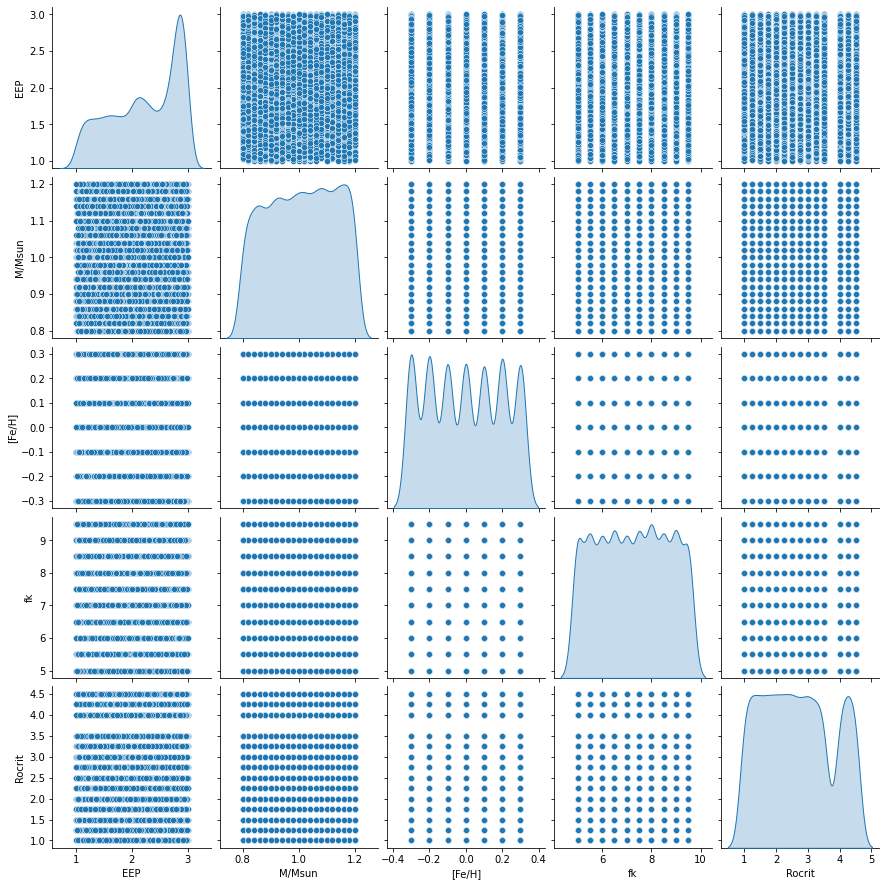

In [10]:
sns.pairplot(df[input_cols].sample(10000), diag_kind='kde');

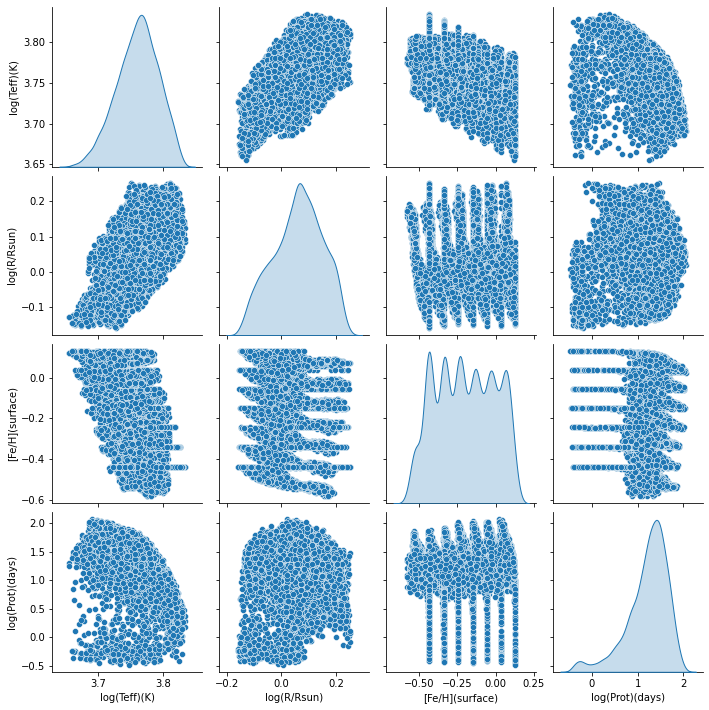

In [11]:
sns.pairplot(df[output_cols].sample(10000), diag_kind='kde');

In [12]:
random_state = 10

train = df.sample(frac=0.8, random_state=10)
test = df.drop(train.index)

In [13]:
print('Train length = ', len(train))
print('Test length = ', len(test))

Train length =  38447873
Test length =  9611968


In [16]:
del df

In [14]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

In [15]:
input_mean = input_normalizer.mean.numpy()
input_var = input_normalizer.variance.numpy()
for col, mean, var in zip(input_cols, input_mean, input_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

EEP            : 2.220e+00, 3.687e-01
M/Msun         : 1.008e+00, 1.475e-02
[Fe/H]         : -2.564e-03, 3.996e-02
fk             : 7.250e+00, 2.062e+00
Rocrit         : 2.679e+00, 1.173e+00


In [17]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

In [18]:
output_mean = output_normalizer.mean.numpy()
output_var = output_normalizer.variance.numpy()
for col, mean, var in zip(output_cols, output_mean, output_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Teff)(K)   : 3.761e+00, 1.023e-03
log(R/Rsun)    : 6.034e-02, 8.027e-03
[Fe/H](surface): -2.013e-01, 3.561e-02
log(Prot)(days): 1.195e+00, 2.106e-01


In [19]:
output_rescaler = preprocessing.Rescaling(scale=tf.sqrt(output_normalizer.variance), offset=output_normalizer.mean)

In [20]:
def build_model(n_neurons, n_hidden, activation='elu'):
    hidden_layers = [layers.Dense(n_neurons, activation=activation) for layer in range(n_hidden)]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    model = keras.Sequential(all_layers)
    return model

In [21]:
model = build_model(128, 6)

In [22]:
learning_rate = 1e-4
momentum = 0.999

model.compile(loss='mean_squared_error',
#              optimizer=keras.optimizers.SGD(learning_rate, momentum=momentum),
             optimizer=keras.optimizers.Adam()
             )

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [24]:
batch_size = 2048

print('Number of batches:', len(train)//batch_size)
print('Remainder:', len(train)%batch_size)

Number of batches: 37546
Remainder: 769


In [25]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=0.2,
    batch_size=batch_size,
    verbose=0, epochs=100,
)

CPU times: user 4h 34min 18s, sys: 24min 32s, total: 4h 58min 50s
Wall time: 2h 52min 27s


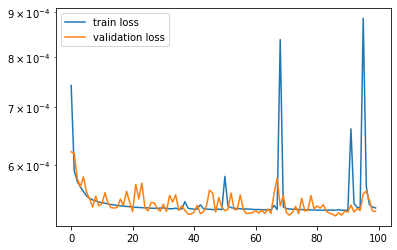

In [26]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')

plt.yscale('log')
plt.legend()

In [27]:
pred = pd.DataFrame(model(test[input_cols]).numpy(), columns=output_cols)
pred.head()

,log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days)
0,3.757452,-0.022577,-0.051573,-0.391288
1,3.758250,-0.021575,-0.057937,0.242084
2,3.760847,-0.014977,-0.059629,0.558930
3,3.760288,-0.011528,-0.061062,0.815195
4,3.760909,-0.006277,-0.065310,0.918089


In [36]:
error.head()

,log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days),10^log(Teff)(K),10^log(R/Rsun),10^log(Prot)(days)
0,-0.005589,0.013485,-0.002837,-0.024824,-73.152124,0.029940,-0.022565
1,-0.005161,0.016161,0.002719,-0.066403,-67.702838,0.036075,-0.247575
2,-0.007331,0.011369,0.003338,-0.043392,-96.507227,0.025624,-0.344379
3,-0.006030,0.012593,0.001049,-0.015155,-79.395923,0.028651,-0.224082
4,-0.005977,0.011571,0.001608,0.000494,-78.817291,0.026614,0.009420


In [29]:
truth = test[output_cols].reset_index(drop=True)
error = truth - pred
frac_error = (truth - pred) / truth

In [30]:
log_cols = ['log(Teff)(K)', 'log(R/Rsun)', 'log(Prot)(days)']

for col in log_cols:
    error[f'10^{col}'] = 10**truth[col] - 10**pred[col]
    frac_error[f'10^{col}'] = (10**truth[col] - 10**pred[col]) / 10**truth[col]

In [31]:
error.mean()

log(Teff)(K)         -0.000358
log(R/Rsun)          -0.000524
[Fe/H](surface)      -0.000873
log(Prot)(days)      -0.003660
10^log(Teff)(K)      -4.095064
10^log(R/Rsun)       -0.000963
10^log(Prot)(days)   -0.161001
dtype: float64

In [32]:
error.std()

log(Teff)(K)           0.006622
log(R/Rsun)            0.012134
[Fe/H](surface)        0.013184
log(Prot)(days)        0.041779
10^log(Teff)(K)       87.462884
10^log(R/Rsun)         0.034685
10^log(Prot)(days)     1.343287
dtype: float64

In [33]:
frac_error.mean()

log(Teff)(K)         -0.000098
log(R/Rsun)          -0.004799
[Fe/H](surface)       0.020289
log(Prot)(days)      -0.001543
10^log(Teff)(K)      -0.000941
10^log(R/Rsun)       -0.001598
10^log(Prot)(days)   -0.013163
dtype: float64

In [34]:
frac_error.std()

log(Teff)(K)           0.001763
log(R/Rsun)           27.005847
[Fe/H](surface)        6.890379
log(Prot)(days)       10.757631
10^log(Teff)(K)        0.015289
10^log(R/Rsun)         0.027908
10^log(Prot)(days)     0.099820
dtype: float64

In [43]:
tf.keras.models.save_model(model, 'data/models/test_model')

TypeError: ('Not JSON Serializable:', <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.0319775 , 0.08959194, 0.18869294, 0.45887634], dtype=float32)>)